Collect stock and option data, price with BSM, compare accuracy

In [1]:
# !pip install yfinance
# !pip install seaborn

import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

In [5]:
from datetime import datetime, timezone, timedelta

# exp of Nov 16 2020

timestamp = 1605484800 # exp of Nov 16 2020
# timestamp = 1605657600 # exp of Nov 18 2020

datetime.fromtimestamp(timestamp) # need to add 5 hours (same as UTC)

# create a timestamp for scraping from a given date and time (UTC)
# expiration_datetime = datetime(2020, 11, 16, 0, 0, tzinfo=timezone.utc)\
expiration_datetime = datetime(2020, 12, 4, 0, 0, tzinfo=timezone.utc)

expiration_timestamp = int(expiration_datetime.timestamp())
print(expiration_timestamp)

1607040000


In [26]:
print(expiration_datetime.date())

2020-12-04


Download historical stock price data for SPY. I get a past year's worth from (https://finance.yahoo.com/quote/SPY/history?p=SPY)

In [7]:
# download annual historical data for the stock

ticker = 'TSLA'
stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

# get options data
options_data_path = 'https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, expiration_timestamp, ticker)
r = pd.read_html(options_data_path)[0]

print(df)
print(r)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-11-14   69.222000   70.767998   68.582001   69.870003   69.870003   
1    2019-11-15   70.127998   70.559998   69.671997   70.433998   70.433998   
2    2019-11-18   70.584000   70.629997   69.220001   69.998001   69.998001   
3    2019-11-19   70.349998   71.998001   69.559998   71.903999   71.903999   
4    2019-11-20   72.000000   72.239998   69.914001   70.444000   70.444000   
..          ...         ...         ...         ...         ...         ...   
248  2020-11-09  439.500000  452.500000  421.000000  421.260010  421.260010   
249  2020-11-10  420.089996  420.089996  396.029999  410.359985  410.359985   
250  2020-11-11  416.450012  418.700012  410.579987  417.130005  417.130005   
251  2020-11-12  415.049988  423.000000  409.519989  411.760010  411.760010   
252  2020-11-13  410.850006  412.529999  401.660004  408.500000  408.500000   

       Volume  close_day_before   returns  
0    32

In [8]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [15]:
df.shape

(253, 9)

In [16]:
cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)
risk_free_rate = 0.0069
# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, r.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = (time_to_expiration), 
                            r = risk_free_rate, 
                            sigma = sigma)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 408.5, time to expiration: 0.07539682539682539, rfr: 0.0069, vol: 0.8736802392964274


In [17]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,TSLA201204C00020000,2020-11-09 1:36PM EST,20.0,411.95,387.80,392.40,0.00,-,-,-,693.95%,388.509498
1,TSLA201204C00250000,2020-11-10 12:27PM EST,250.0,160.40,156.90,161.35,0.00,-,1,4,101.42%,159.159113
2,TSLA201204C00260000,2020-11-10 12:50PM EST,260.0,153.00,153.75,157.90,0.00,-,-,-,160.41%,149.526842
3,TSLA201204C00280000,2020-11-10 11:42AM EST,280.0,128.85,135.15,140.05,0.00,-,-,-,149.90%,130.436772
4,TSLA201204C00290000,2020-11-13 3:21PM EST,290.0,117.45,117.50,122.00,-29.00,-19.80%,1,5,83.81%,120.983877
...,...,...,...,...,...,...,...,...,...,...,...,...
71,TSLA201204C00720000,2020-11-13 10:25AM EST,720.0,0.11,0.11,0.14,-0.10,-47.62%,2,6,87.89%,-212.840024
72,TSLA201204C00740000,2020-11-10 1:06PM EST,740.0,0.15,0.01,0.13,0.00,-,3,7,86.52%,-224.839304
73,TSLA201204C00760000,2020-11-12 2:33PM EST,760.0,0.10,0.02,0.46,0.00,-,2,17,101.95%,-236.548803
74,TSLA201204C00780000,2020-11-13 2:51PM EST,780.0,0.11,0.05,0.17,0.01,+10.00%,6,34,97.27%,-247.973355


<AxesSubplot:title={'center':'Computed v Market prices for TSLA, Expiry 2020-12-04'}, xlabel='Strike'>

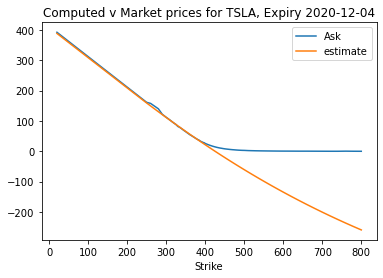

In [28]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Ask','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

count      76.000000
mean        0.880386
std       526.458820
min      -878.813618
25%      -102.842233
50%       -51.265040
75%         1.872844
max      4338.546470
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


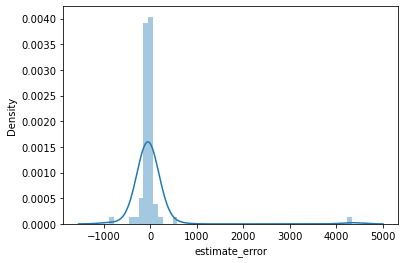

In [19]:
df_estimate['estimate_error'] = ((df_estimate['Ask'] - df_estimate['estimate'])/df_estimate['estimate'])*100

ax = sns.distplot(df_estimate['estimate_error'])

print(df_estimate['estimate_error'].describe())

# across strikes, the median error is .34%, but there is a huge spread and there are huge outliers. Why?

In [20]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# appears to be strikes from 330 to 360. 
# The error explodes as the strikes approaches the current stock price. This needs investigation

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,TSLA201204C00020000,2020-11-09 1:36PM EST,20.0,411.95,387.80,392.40,0.00,-,-,-,693.95%,388.509498,1.001392
1,TSLA201204C00250000,2020-11-10 12:27PM EST,250.0,160.40,156.90,161.35,0.00,-,1,4,101.42%,159.159113,1.376539
2,TSLA201204C00260000,2020-11-10 12:50PM EST,260.0,153.00,153.75,157.90,0.00,-,-,-,160.41%,149.526842,5.599769
3,TSLA201204C00280000,2020-11-10 11:42AM EST,280.0,128.85,135.15,140.05,0.00,-,-,-,149.90%,130.436772,7.370029
10,TSLA201204C00330000,2020-11-11 3:44PM EST,330.0,76.00,79.05,81.85,-13.30,-14.89%,1,8,62.78%,83.835844,-2.368729
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,TSLA201204C00720000,2020-11-13 10:25AM EST,720.0,0.11,0.11,0.14,-0.10,-47.62%,2,6,87.89%,-212.840024,-100.065777
72,TSLA201204C00740000,2020-11-10 1:06PM EST,740.0,0.15,0.01,0.13,0.00,-,3,7,86.52%,-224.839304,-100.057819
73,TSLA201204C00760000,2020-11-12 2:33PM EST,760.0,0.10,0.02,0.46,0.00,-,2,17,101.95%,-236.548803,-100.194463
74,TSLA201204C00780000,2020-11-13 2:51PM EST,780.0,0.11,0.05,0.17,0.01,+10.00%,6,34,97.27%,-247.973355,-100.068556


<AxesSubplot:xlabel='Strike'>

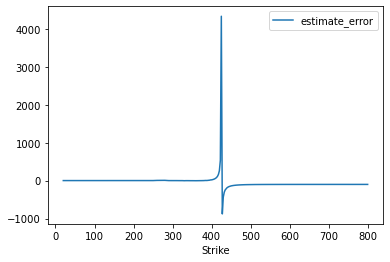

In [21]:
# plot the error across strikes

# df_estimate.plot(x='Strike',y='estimate_error',logy=True)
df_estimate.plot(x='Strike',y='estimate_error')

In [ ]:
# compare (estimated) historical vol to implied vol